In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
from typing import Callable

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from functools import partial
import numpy as np

import blackjax
import h5py
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy import stats
import matplotlib.pyplot as plt
from jax import jit as jjit
from jax import random, vmap
from jax import random
from tqdm import tqdm

from jax import random

from bpd.measure import get_snr
from bpd.diagnostics import get_contour_plot
from bpd.chains import inference_loop

jax.config.update("jax_enable_x64", True)

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Check target images

(array([1195., 1155., 1132., 1026.,  972.,  827.,  733.,  637.,  495.,
         468.,  366.,  258.,  200.,  172.,  106.,   89.,   59.,   42.,
          24.,   25.,   11.,    3.,    3.,    0.,    2.]),
 array([0.        , 0.00148664, 0.00297328, 0.00445992, 0.00594657,
        0.00743321, 0.00891985, 0.01040649, 0.01189313, 0.01337977,
        0.01486641, 0.01635306, 0.0178397 , 0.01932634, 0.02081298,
        0.02229962, 0.02378626, 0.02527291, 0.02675955, 0.02824619,
        0.02973283, 0.03121947, 0.03270611, 0.03419275, 0.0356794 ,
        0.03716604]),
 <BarContainer object of 25 artists>)

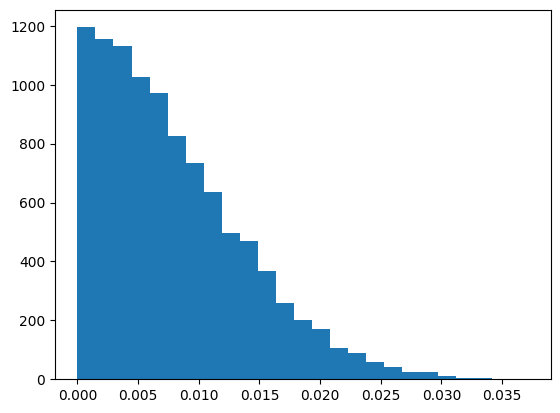

In [8]:
# look at prior samples for intuition
from bpd.prior import sample_mag_ellip_prior
emag_samples = sample_mag_ellip_prior(random.key(44), sigma=1e-2, n=10_000)
plt.hist(emag_samples, bins=25)

In [54]:
SEED = 43
rng_key = random.key(SEED)
pkey, nkey, k1 = random.split(rng_key, 3)

In [55]:
# setup
from bpd.pipelines.image_ellips import get_target_galaxy_params_simple

g1 = 0.02
g2 = 0.0
lf = 4.0 # 4.5=96, 6=1000
hlr = 1.0
sigma_e=1e-3
sigma_e_int = 1e-2 # size of at least shear!!
background = 1.0

galaxy_params = get_target_galaxy_params_simple(pkey, lf=lf, g1=g1, g2=g2, hlr=hlr, sigma_e=sigma_e)
galaxy_params

{'lf': 4.0,
 'hlr': 1.0,
 'e1': Array(0.0002706, dtype=float64),
 'e2': Array(4.89806201e-05, dtype=float64),
 'x': 0.0,
 'y': 0.0,
 'g1': 0.02,
 'g2': 0.0}

In [56]:
from bpd.pipelines.image_ellips import get_target_images_single

draw_params = {**galaxy_params}
draw_params['f'] = 10**draw_params.pop('lf')

target_images, nn = get_target_images_single(nkey, 10, draw_params, background=background)
target_images.shape, nn.shape

((10, 53, 53), (53, 53))

SNR: 96.469574


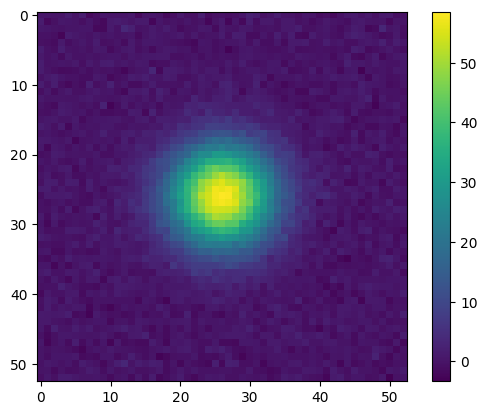

In [57]:
plt.imshow(target_images[0])
print('SNR:', get_snr(nn, background))
plt.colorbar()

In [58]:
# # how to initialize chains
# from bpd.initialization import init_with_truth
# init_fnc = vmap(init_with_truth, (0, None))

# # testing init function
# init_key, k2 = random.split(k1)
# init_keys = random.split(init_key, 10)
# init_positions = init_fnc(init_keys, galaxy_params)



In [59]:
from bpd.initialization import init_with_truth
init_fnc = init_with_truth

In [60]:
# true params should exclude g1, g2 and start on sheared ones. 
from bpd.prior import scalar_shear_transformation
true_params = {**galaxy_params}
e1, e2 = true_params.pop('e1'), true_params.pop('e2')
g1, g2 = true_params.pop('g1'), true_params.pop('g2')

e1_prime, e2_prime = scalar_shear_transformation((e1, e2), (g1, g2))
true_params['e1'] = e1_prime
true_params['e2'] = e2_prime

true_params

{'lf': 4.0,
 'hlr': 1.0,
 'x': 0.0,
 'y': 0.0,
 'e1': Array(0.02027049, dtype=float64),
 'e2': Array(4.89604979e-05, dtype=float64)}

In [61]:
# check it works on 1 image
from bpd.pipelines.image_ellips import pipeline_image_interim_samples
pipeline1 = partial(pipeline_image_interim_samples, initialization_fnc=init_fnc, 
                    background=background, 
                    initial_step_size=1e-3, 
                    n_samples=1000,
                   sigma_e_int=sigma_e_int,)
samples = pipeline1(k1, true_params, target_images[0])

In [62]:
samples['e1'].shape

(1000,)

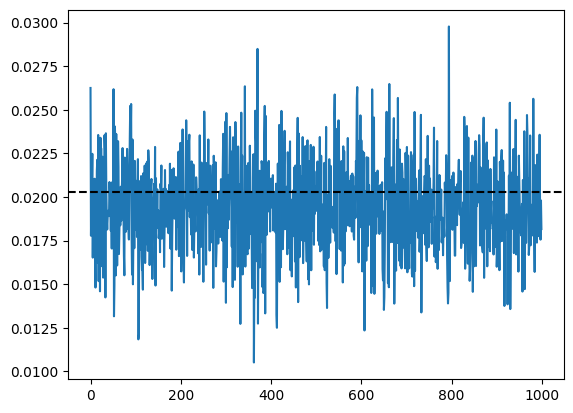

In [63]:
# check trace plots
plt.plot(samples['e1'])
plt.axhline(true_params['e1'], color='k', linestyle='--')

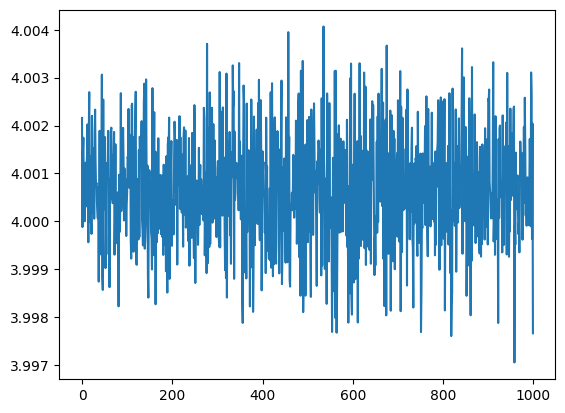

In [65]:
# check trace plots
plt.plot(samples['lf'])

In [56]:

_run_pipeline1 = partial(
    pipeline_image_interim_samples, 
    initialization_function=init_fnc,
    n_samples=100,
    max_num_doublings=5,
    init_step_size=1e-2,
    n_warmup_steps=500,
    is_mass_matrix_diagonal=False, 
    background=background,)

_run_pipeline = vmap(jjit(_run_pipeline1), (0, None, 0))
    


In [ ]:
ikeys = random.split(k1, 10)